# validation.ipynb

Validation implementation.

Author: Connacher Murphy

In [1]:
# Libraries
import pest_classification as pest

import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.model_selection import StratifiedKFold
import timm
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from types import SimpleNamespace

In [2]:
# Use a super small sample for quick testing
quickly = True

In [3]:
def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    # PyTorch seed
    torch.manual_seed(seed)
    
    # CUDA 1 GPU seed
    torch.cuda.manual_seed(seed)
    
    # CUDA multi-GPU seed
    torch.cuda.manual_seed_all(seed)
    
    # Force deterministic operations in cudnn
    torch.backends.cudnn.deterministic = True 
    
    # Disable cudnn auto-tuner
    torch.backends.cudnn.benchmark = False

In [4]:
# Set random seed
set_seed(123)

In [5]:
# Configuration
config = SimpleNamespace(**{})

# Grab training observations from images df
# CM: sampling to speed up execution
df_all = pest.df

if quickly:  # select small sample
    config.total_size = 256
    config.batch_size = 32
    config.num_epochs = 2
else:  # "full" sample
    config.total_size = 2048
    config.batch_size = 64
    config.num_epochs = 4

df = df_all[df_all["set"] == "train"].sample(config.total_size)
df = df.reset_index(drop=True)

In [6]:
# Dataset and dataloader
# config.image_dir = os.path.expanduser("~/data/ccmt/CCMT Dataset-Augmented")
# config.image_size = 256

In [7]:
# Add folds to the dataframe
config.n_folds = 4

skf = StratifiedKFold(n_splits=config.n_folds)
# CM: should I add a shuffle here?
# skf = StratifiedKFold(n_splits=config.n_folds, shuffle=True)

In [8]:
# Partition into folds
for fold, (train_index, val_index) in enumerate(skf.split(df, df.label)):
    df.loc[val_index, "fold"] = fold

In [9]:
# Specify architecture parameters
config.num_classes = len(pest.crop_descriptions["Maize"])
# config.num_classes = 2
config.backbone = "resnet18"

# Specify optimizer parameters
config.lr = 1e-4

In [10]:
# Select GPU if available
print(torch.cuda.is_available())
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

False


In [11]:
# Training function
def train(train_dataloader, valid_dataloader, model, optimizer, config):
    train_loss_history = []
    train_accuracy_history = []
    valid_loss_history = []
    valid_accuracy_history = []

    for epoch in range(config.num_epochs):
        print(f"Epoch {epoch + 1}")
        print("Training...")
        model, train_loss, train_accuracy, train_tab = pest.train_epoch(
            train_dataloader, model, optimizer, config
        )

        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        train_tab_sum = np.sum(train_tab, axis=1, keepdims=True)

        print(f"Training: loss = {train_loss}, accuracy = {train_accuracy}")
        print("Label versus predicted label tabulation:")
        print(np.round(train_tab / train_tab_sum, 2))
        print(train_tab_sum)
        print("\n")

        print("Validating...")
        valid_loss, valid_accuracy, valid_tab = pest.validate_epoch(
            valid_dataloader, model, config
        )

        valid_loss_history.append(valid_loss)
        valid_accuracy_history.append(valid_accuracy)

        valid_tab_sum = np.sum(train_tab, axis=1, keepdims=True)

        print(f"Validation: loss = {valid_loss}, accuracy = {valid_accuracy}")
        print("Label versus predicted label tabulation:")
        print(np.round(valid_tab / valid_tab_sum, 2))
        print(valid_tab_sum)
        print("\n")

    return (
        train_loss_history,
        train_accuracy_history,
        valid_loss_history,
        valid_accuracy_history,
    )

Fold 0


Epoch 1
Training...


100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Training: loss = 1.9268235564231873, accuracy = 0.14583333333333334
Label versus predicted label tabulation:
[[0.22 0.   0.   0.   0.44 0.33 0.  ]
 [0.4  0.16 0.08 0.   0.24 0.08 0.04]
 [0.   0.   0.14 0.   0.43 0.29 0.14]
 [0.25 0.12 0.12 0.03 0.41 0.03 0.03]
 [0.11 0.06 0.2  0.   0.26 0.34 0.03]
 [0.12 0.02 0.21 0.02 0.35 0.23 0.05]
 [0.02 0.05 0.12 0.   0.51 0.27 0.02]]
[[ 9.]
 [25.]
 [ 7.]
 [32.]
 [35.]
 [43.]
 [41.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Validation: loss = 1.9266186952590942, accuracy = 0.21875
Label versus predicted label tabulation:
[[0.   0.   0.   0.   0.   0.22 0.  ]
 [0.04 0.08 0.   0.   0.04 0.2  0.  ]
 [0.   0.   0.   0.   0.   0.43 0.  ]
 [0.03 0.09 0.   0.   0.   0.22 0.  ]
 [0.   0.   0.   0.   0.17 0.17 0.  ]
 [0.   0.   0.02 0.02 0.14 0.14 0.  ]
 [0.   0.   0.   0.   0.   0.32 0.  ]]
[[ 9.]
 [25.]
 [ 7.]
 [32.]
 [35.]
 [43.]
 [41.]]


Epoch 2
Training...


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Training: loss = 1.9089841842651367, accuracy = 0.17708333333333334
Label versus predicted label tabulation:
[[0.11 0.   0.   0.   0.22 0.67 0.  ]
 [0.2  0.2  0.   0.   0.28 0.24 0.08]
 [0.   0.   0.   0.   0.86 0.14 0.  ]
 [0.16 0.06 0.03 0.12 0.38 0.19 0.06]
 [0.09 0.   0.09 0.   0.37 0.4  0.06]
 [0.09 0.   0.14 0.02 0.44 0.23 0.07]
 [0.02 0.07 0.02 0.02 0.32 0.51 0.02]]
[[ 9.]
 [25.]
 [ 7.]
 [32.]
 [35.]
 [43.]
 [41.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Validation: loss = 1.8951073288917542, accuracy = 0.21875
Label versus predicted label tabulation:
[[0.   0.   0.   0.   0.   0.22 0.  ]
 [0.   0.12 0.   0.   0.04 0.2  0.  ]
 [0.   0.   0.   0.   0.   0.43 0.  ]
 [0.   0.09 0.   0.03 0.03 0.19 0.  ]
 [0.   0.   0.   0.   0.14 0.17 0.03]
 [0.   0.   0.02 0.02 0.16 0.12 0.  ]
 [0.   0.   0.   0.   0.   0.32 0.  ]]
[[ 9.]
 [25.]
 [ 7.]
 [32.]
 [35.]
 [43.]
 [41.]]




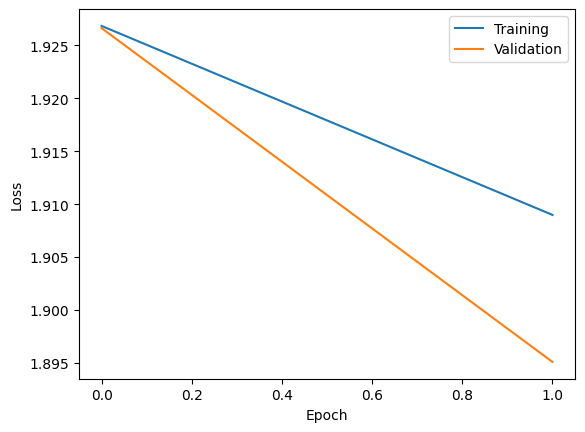

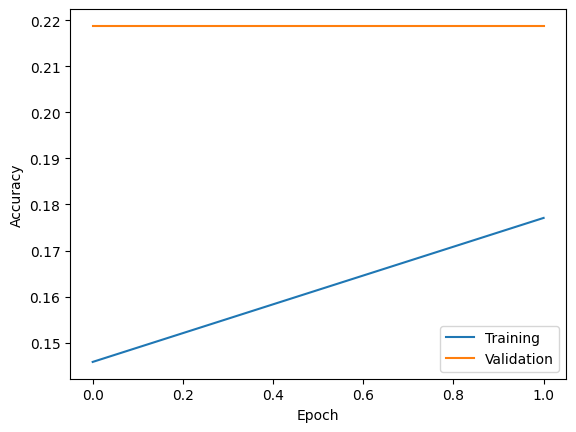



Fold 1
Epoch 1
Training...


100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Training: loss = 1.9171188076337178, accuracy = 0.1875
Label versus predicted label tabulation:
[[0.   0.25 0.25 0.   0.   0.25 0.25]
 [0.   0.15 0.15 0.12 0.04 0.15 0.38]
 [0.   0.   0.57 0.14 0.   0.14 0.14]
 [0.   0.09 0.24 0.15 0.   0.3  0.21]
 [0.   0.17 0.14 0.   0.03 0.34 0.31]
 [0.   0.21 0.12 0.05 0.05 0.29 0.29]
 [0.   0.15 0.1  0.1  0.   0.41 0.24]]
[[ 8.]
 [26.]
 [ 7.]
 [33.]
 [35.]
 [42.]
 [41.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Validation: loss = 1.8870739936828613, accuracy = 0.265625
Label versus predicted label tabulation:
[[0.   0.12 0.   0.   0.   0.12 0.12]
 [0.   0.19 0.04 0.04 0.   0.04 0.  ]
 [0.   0.   0.14 0.   0.   0.29 0.  ]
 [0.   0.06 0.03 0.12 0.03 0.   0.06]
 [0.   0.09 0.   0.06 0.03 0.03 0.14]
 [0.   0.07 0.02 0.17 0.   0.05 0.05]
 [0.   0.02 0.   0.1  0.   0.1  0.1 ]]
[[ 8.]
 [26.]
 [ 7.]
 [33.]
 [35.]
 [42.]
 [41.]]


Epoch 2
Training...


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


Training: loss = 1.8534089128176372, accuracy = 0.34375
Label versus predicted label tabulation:
[[0.   0.12 0.12 0.   0.25 0.5  0.  ]
 [0.   0.27 0.04 0.08 0.12 0.19 0.31]
 [0.   0.   0.14 0.14 0.   0.71 0.  ]
 [0.   0.03 0.   0.36 0.12 0.24 0.24]
 [0.   0.09 0.09 0.03 0.11 0.43 0.26]
 [0.   0.05 0.05 0.   0.05 0.52 0.33]
 [0.   0.07 0.07 0.02 0.   0.34 0.49]]
[[ 8.]
 [26.]
 [ 7.]
 [33.]
 [35.]
 [42.]
 [41.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Validation: loss = 1.8683828711509705, accuracy = 0.375
Label versus predicted label tabulation:
[[0.   0.12 0.   0.   0.   0.12 0.12]
 [0.   0.27 0.   0.   0.   0.04 0.  ]
 [0.   0.   0.14 0.   0.   0.29 0.  ]
 [0.   0.   0.03 0.12 0.03 0.   0.12]
 [0.   0.11 0.   0.03 0.03 0.06 0.11]
 [0.   0.07 0.   0.02 0.   0.17 0.1 ]
 [0.   0.05 0.   0.07 0.   0.1  0.1 ]]
[[ 8.]
 [26.]
 [ 7.]
 [33.]
 [35.]
 [42.]
 [41.]]




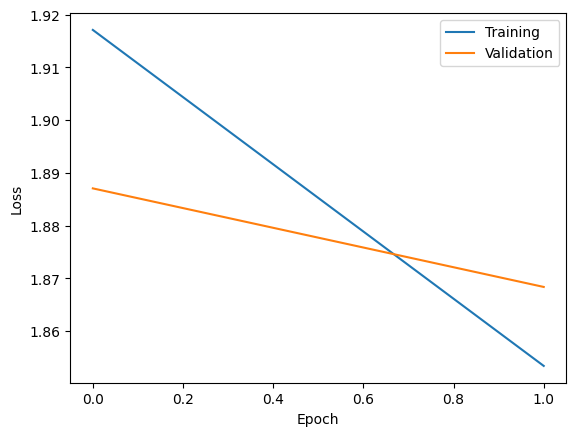

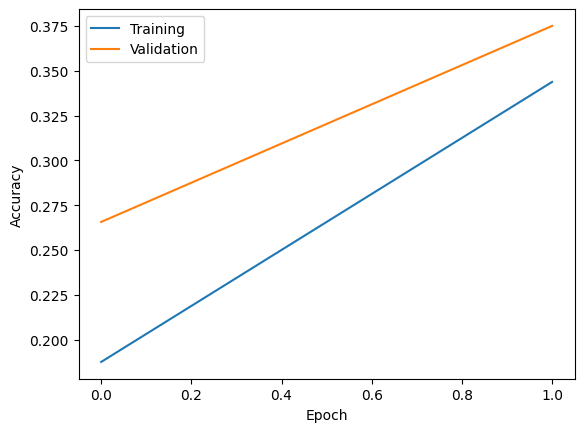



Fold 2
Epoch 1
Training...


100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Training: loss = 1.9857541521390278, accuracy = 0.07291666666666667
Label versus predicted label tabulation:
[[0.62 0.38 0.   0.   0.   0.   0.  ]
 [0.69 0.31 0.   0.   0.   0.   0.  ]
 [0.5  0.38 0.12 0.   0.   0.   0.  ]
 [0.44 0.34 0.12 0.   0.   0.   0.09]
 [0.63 0.29 0.03 0.03 0.   0.   0.03]
 [0.6  0.33 0.02 0.   0.02 0.   0.02]
 [0.57 0.38 0.05 0.   0.   0.   0.  ]]
[[ 8.]
 [26.]
 [ 8.]
 [32.]
 [35.]
 [43.]
 [40.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Validation: loss = 1.9781628251075745, accuracy = 0.09375
Label versus predicted label tabulation:
[[0.38 0.   0.   0.   0.   0.   0.  ]
 [0.19 0.08 0.04 0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.   0.  ]
 [0.22 0.   0.06 0.   0.   0.   0.06]
 [0.2  0.06 0.03 0.   0.   0.03 0.03]
 [0.09 0.14 0.07 0.   0.02 0.   0.  ]
 [0.2  0.1  0.02 0.   0.   0.   0.02]]
[[ 8.]
 [26.]
 [ 8.]
 [32.]
 [35.]
 [43.]
 [40.]]


Epoch 2
Training...


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


Training: loss = 1.931639850139618, accuracy = 0.13541666666666666
Label versus predicted label tabulation:
[[0.25 0.38 0.   0.   0.   0.25 0.12]
 [0.35 0.58 0.08 0.   0.   0.   0.  ]
 [0.38 0.5  0.12 0.   0.   0.   0.  ]
 [0.38 0.38 0.   0.12 0.   0.   0.12]
 [0.46 0.46 0.   0.   0.   0.06 0.03]
 [0.3  0.42 0.02 0.   0.09 0.05 0.12]
 [0.38 0.52 0.02 0.   0.   0.02 0.05]]
[[ 8.]
 [26.]
 [ 8.]
 [32.]
 [35.]
 [43.]
 [40.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Validation: loss = 1.9335660934448242, accuracy = 0.1875
Label versus predicted label tabulation:
[[0.12 0.12 0.   0.   0.   0.12 0.  ]
 [0.15 0.12 0.04 0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.   0.  ]
 [0.09 0.06 0.03 0.03 0.   0.   0.12]
 [0.11 0.11 0.   0.   0.06 0.06 0.  ]
 [0.07 0.09 0.02 0.   0.07 0.07 0.  ]
 [0.08 0.12 0.02 0.   0.   0.08 0.05]]
[[ 8.]
 [26.]
 [ 8.]
 [32.]
 [35.]
 [43.]
 [40.]]




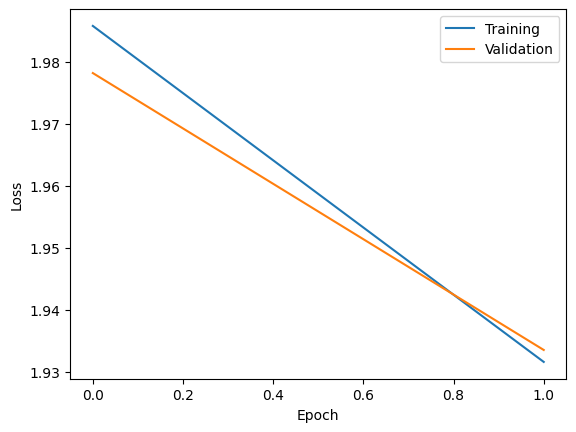

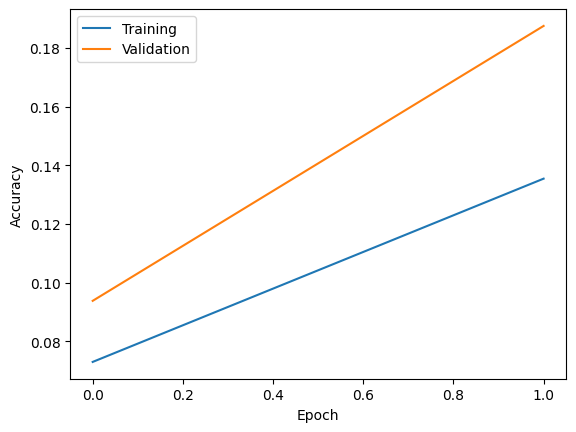



Fold 3
Epoch 1
Training...


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Training: loss = 1.9314319491386414, accuracy = 0.15625
Label versus predicted label tabulation:
[[0.   0.12 0.12 0.38 0.12 0.   0.25]
 [0.   0.12 0.2  0.6  0.04 0.   0.04]
 [0.   0.25 0.   0.75 0.   0.   0.  ]
 [0.   0.03 0.22 0.75 0.   0.   0.  ]
 [0.   0.19 0.25 0.44 0.06 0.   0.06]
 [0.   0.12 0.12 0.72 0.05 0.   0.  ]
 [0.   0.12 0.   0.85 0.   0.   0.02]]
[[ 8.]
 [25.]
 [ 8.]
 [32.]
 [36.]
 [43.]
 [40.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Validation: loss = 1.9280605912208557, accuracy = 0.171875
Label versus predicted label tabulation:
[[0.   0.   0.   0.25 0.   0.   0.12]
 [0.   0.   0.12 0.24 0.   0.   0.  ]
 [0.   0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.03 0.31 0.   0.   0.  ]
 [0.   0.   0.   0.22 0.03 0.   0.06]
 [0.   0.   0.   0.33 0.   0.   0.  ]
 [0.   0.   0.   0.35 0.   0.   0.  ]]
[[ 8.]
 [25.]
 [ 8.]
 [32.]
 [36.]
 [43.]
 [40.]]


Epoch 2
Training...


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Training: loss = 1.8815927306811016, accuracy = 0.21875
Label versus predicted label tabulation:
[[0.   0.12 0.   0.5  0.   0.   0.38]
 [0.   0.2  0.16 0.56 0.04 0.04 0.  ]
 [0.   0.12 0.   0.75 0.   0.12 0.  ]
 [0.   0.   0.03 0.94 0.   0.03 0.  ]
 [0.   0.08 0.03 0.58 0.14 0.03 0.14]
 [0.   0.09 0.05 0.72 0.12 0.   0.02]
 [0.   0.1  0.   0.8  0.02 0.02 0.05]]
[[ 8.]
 [25.]
 [ 8.]
 [32.]
 [36.]
 [43.]
 [40.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

Validation: loss = 1.8829233050346375, accuracy = 0.203125
Label versus predicted label tabulation:
[[0.   0.   0.   0.25 0.   0.   0.12]
 [0.   0.04 0.08 0.24 0.   0.   0.  ]
 [0.   0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.34 0.   0.   0.  ]
 [0.   0.   0.   0.22 0.03 0.   0.06]
 [0.   0.   0.   0.28 0.05 0.   0.  ]
 [0.   0.05 0.   0.3  0.   0.   0.  ]]
[[ 8.]
 [25.]
 [ 8.]
 [32.]
 [36.]
 [43.]
 [40.]]




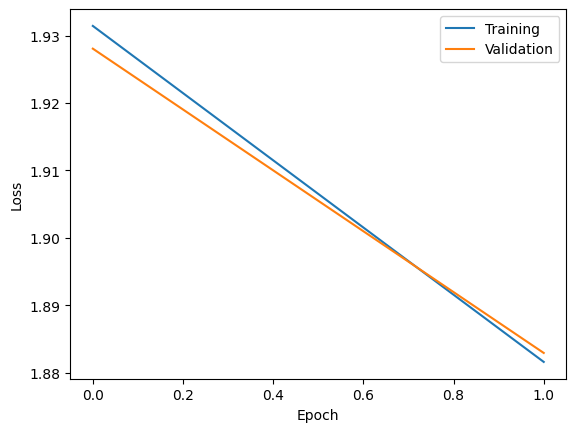

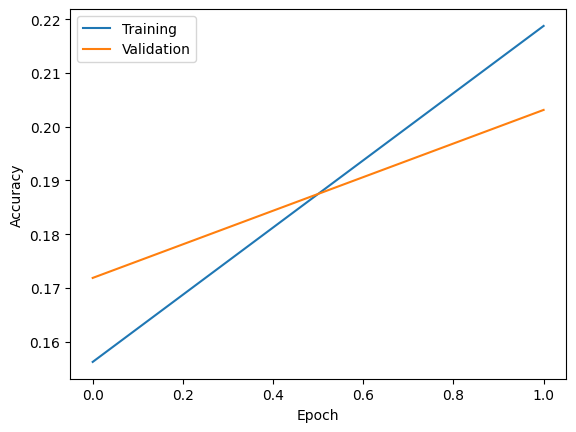

In [12]:
for fold in range(config.n_folds):
    print(f"Fold {fold}")

    # Split into training and validation sets
    train_df = df[df["fold"] != fold].reset_index(drop=True)
    valid_df = df[df["fold"] == fold].reset_index(drop=True)

    train_dataset = pest.AugmentedCCMT(config, train_df, transform=pest.transform_train)
    valid_dataset = pest.AugmentedCCMT(config, valid_df)

    # Dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=0,
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=0,
    )

    # Initialize (pre-trained) model
    model = timm.create_model(
        config.backbone, pretrained=True, num_classes=config.num_classes
    )
    model.to(config.device)

    # Specify loss function (CM: move this to outer loop?)
    config.criterion = nn.CrossEntropyLoss()

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=0.0)

    # Call training function
    (
        train_loss_history,
        train_accuracy_history,
        valid_loss_history,
        valid_accuracy_history,
    ) = train(train_dataloader, valid_dataloader, model, optimizer, config)

    plt.plot(train_loss_history, label="Training")
    plt.plot(valid_loss_history, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(train_accuracy_history, label="Training")
    plt.plot(valid_accuracy_history, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print("\n")